<a href="https://colab.research.google.com/github/ruizleandro/Credit-Card-Fraud-Detection/blob/master/Model_Development_and_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries Installation

In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Getting the Data

[Link to dataset's Kaggle page](https://www.kaggle.com/mlg-ulb/creditcardfraud)

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving credit_card_fraud_detection.csv to credit_card_fraud_detection.csv
User uploaded file "credit_card_fraud_detection.csv" with length 150828752 bytes


In [0]:
df = pd.read_csv('credit_card_fraud_detection.csv')

# Model Selection

## Data Scaling and Splitting

In [0]:
x_data = df.copy().drop(['Class'], axis=1)
y_data = df['Class'].copy()

In [0]:
from sklearn.preprocessing import StandardScaler
featuresToScale = x_data.columns
scaler = StandardScaler(copy=True)
x_data.loc[:,featuresToScale] = scaler.fit_transform(x_data[featuresToScale])

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size=0.33,
                                                    random_state=2018,
                                                    stratify=y_data)

## Functions Build

Explain breifly every function and later add a step by step summary with comments.

In [0]:
def reconstructionScores(original_df, inversed_df):
  # here explain why this calculus (think is the formula for rec error)
  loss = np.sum((np.array(original_df) - np.array(inversed_df)) ** 2, axis=1)
  # here explain pd.Series and why you use it
  loss = pd.Series(data=loss, index=original_df.index) # creating an array
  # here explain the following calculus
  loss = (loss - np.min(loss)) / (np.max(loss) - np.min(loss))
  return loss

In [0]:
# plotting function
def scatterPlot(data_x, data_y, algorithm_name):
  df_plot = pd.DataFrame(data=data_x.loc[:,0:1], index=data_x.index)
  df_plot = pd.concat((df_plot, data_y), axis=1, join='inner')
  df_plot.columns = ['1st vector', '2nd vector', 'Label']
  sns.lmplot(x='1st vector', y='2nd vector', hue='Label',
             data=df_plot, fit_reg=False)
  ax = plt.gca()
  ax.set_title("Separation of Observations using " + algorithm_name)

In [0]:
# evaluation metrics
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

## Principal Component Analysis

In [0]:
from sklearn.decomposition import PCA

n_components = 27
whiten = False

pca = PCA(n_components=n_components, whiten=whiten, random_state=42)

X_train_pca = pca.fit_transform(X_train)
X_train_pca = pd.DataFrame(data=X_train_pca, index=X_train.index)

X_train_inverse = pca.inverse_transform(X_train_pca)
X_train_inverse = pd.DataFrame(data=X_train_inverse, index=X_train.index)

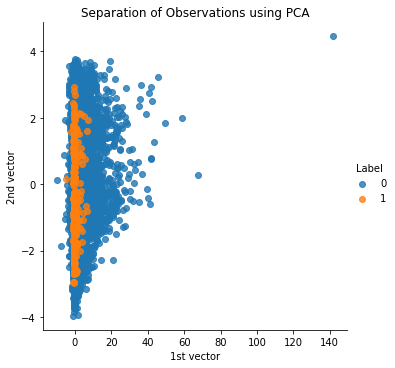

In [0]:
scatterPlot(X_train_pca, y_train, 'PCA')

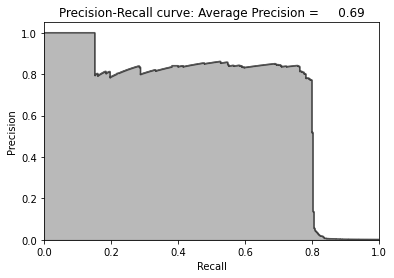

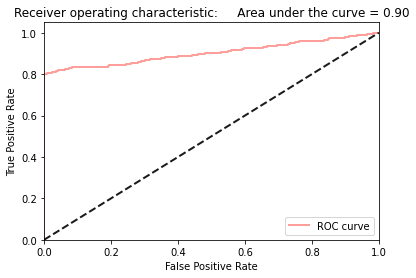

In [0]:
anomaly_scores_pca = reconstructionScores(X_train, X_train_inverse)
preds = plotResults(y_train, anomaly_scores_pca, True)

## Independent Component Analysis

Explica las principales diferencias entre ICA y PCA.

In [0]:
from sklearn.decomposition import FastICA

fastICA = FastICA(n_components=27, algorithm='parallel', whiten=True,
                  max_iter=200, random_state=42)

X_train_ica = fastICA.fit_transform(X_train)
X_train_ica = pd.DataFrame(data=X_train_ica, index=X_train.index)

X_train_ica_inverse = fastICA.inverse_transform(X_train_ica)
X_train_ica_inverse = pd.DataFrame(data=X_train_ica_inverse, index=X_train.index)

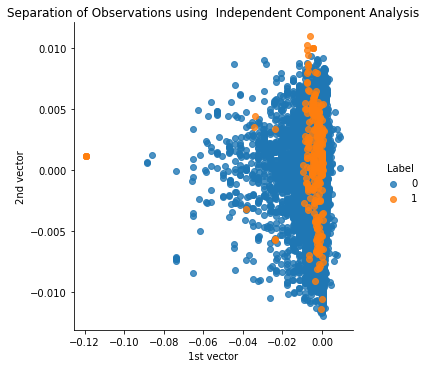

In [0]:
scatterPlot(X_train_ica, y_train, ' Independent Component Analysis')

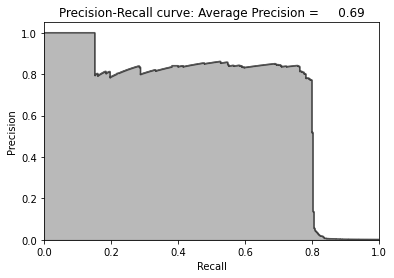

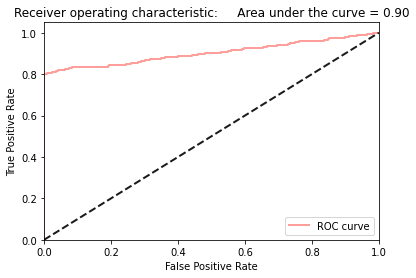

In [0]:
anomaly_scores_ica = reconstructionScores(X_train, X_train_ica_inverse)
preds = plotResults(y_train, anomaly_scores_ica, True)

## One-Class SVM

In [0]:
x_normal = Not_fraud.drop('Class', 1)

X_train = x_normal.loc[0:200000, :]
X_test = x_normal.loc[200000:, :].append(Fraud.drop('Class', 1))

y_fraud = Fraud['Class']
y_test = Not_fraud.loc[200000:, 'Class'].append(y_fraud)

In [0]:
from sklearn.svm import OneClassSVM

svm = OneClassSVM()

svm.fit(X_train)

In [0]:
# test the model

svm_pred = svm.predict(X_test)

In [0]:
# number of outliers

unique, counts = np.unique(svm_pred, return_counts=True)
print(np.asarray(unique, counts).T)

In [0]:
# converting Y_test and svm_pred to dataframe for ease of operation
Y_test = Y_test.to_frame().reset_index()
svm_pred = pd.DataFrame(svm_pred).rename(columns={0: 'Prediction'})

# Hyperparameter Tuning